In [1]:
from collections import defaultdict
import itertools
import jax
import numpy as np

from benchmark import benchmark_chains, cumulative_avg, err, ess, get_num_latents
import blackjax
from blackjax.adaptation.mclmc_adaptation import MCLMCAdaptationState
from blackjax.mcmc.mhmclmc import rescale
from blackjax.util import run_inference_algorithm
import jax.numpy as jnp 

from inference_models import models

def sampler_mhmclmc(step_size, L):

    def s(logdensity_fn, num_steps, initial_position, key):

        init_key, tune_key, key = jax.random.split(key, 3)

        initial_state = blackjax.mcmc.mhmclmc.init(
        position=initial_position, logdensity_fn=logdensity_fn, random_generator_arg=init_key
        )
        kernel = lambda rng_key, state, avg_num_integration_steps, step_size: blackjax.mcmc.mhmclmc.build_kernel(
                integrator=blackjax.mcmc.integrators.isokinetic_mclachlan,
                integration_steps_fn = lambda key: jnp.round(jax.random.uniform(key) * rescale(avg_num_integration_steps + 0.5)), 
            )(
                rng_key=rng_key, 
                state=state, 
                step_size=step_size, 
                logdensity_fn=logdensity_fn)

        jax.debug.print("params before tuning {x}", x=MCLMCAdaptationState(L=L, step_size=step_size))
        (
            blackjax_state_after_tuning,
            blackjax_mclmc_sampler_params,
        ) = blackjax.adaptation.mclmc_adaptation.mhmclmc_find_L_and_step_size(
            mclmc_kernel=kernel,
            num_steps=num_steps,
            state=initial_state,
            rng_key=tune_key,
            frac_tune2=0,
            frac_tune3=0,
            params=MCLMCAdaptationState(L=L, step_size=step_size)
        )

        jax.debug.print("params {x}", x=blackjax_mclmc_sampler_params)
        # jax.debug.print("acceptance rate {x}", x=blackjax_mclmc_sampler_params)

        num_steps_per_traj = L/step_size
        alg = blackjax.mcmc.mhmclmc.mhmclmc(
        logdensity_fn=logdensity_fn,
        step_size=step_size,
        integration_steps_fn = lambda k: jnp.round(jax.random.uniform(k) * rescale(num_steps_per_traj+ 0.5)) ,
        # integration_steps_fn = lambda _ : 5,
        # integration_steps_fn = lambda key: jnp.ceil(jax.random.poisson(key, L/step_size )) ,

        )
        
        _, out, info = run_inference_algorithm(
        rng_key=key,
        initial_state_or_position=initial_position,
        inference_algorithm=alg,
        num_steps=num_steps, 
        transform=lambda x: x.position, 
        progress_bar=True)

        print(out.mean(axis=0))

        print(info.acceptance_rate.mean(), "acceptance probability\n\n\n\n")
        # print(out.var(axis=0), "acceptance probability")

        return out, num_steps_per_traj

    return s

results = defaultdict(float)

# def benchmark(model, sampler, n=100000):



#     identity_fn = model.sample_transformations['identity']
#     # print('True mean', identity_fn.ground_truth_mean)
#     # print('True std', identity_fn.ground_truth_standard_deviation)
#     # print("Empirical mean", samples.mean(axis=0))
#     # print("Empirical std", samples.std(axis=0))

#     logdensity_fn = model.unnormalized_log_prob
#     d = get_num_latents(model)
#     initial_position = jax.random.normal(jax.random.PRNGKey(0), (d,))
#     samples, num_steps_per_traj = sampler(logdensity_fn, n, initial_position, jax.random.PRNGKey(0))
#     # print(samples[-1], samples[0], "samps", samples.shape)

#     favg, fvar = identity_fn.ground_truth_mean, identity_fn.ground_truth_standard_deviation**2
#     err_t = err(favg, fvar, jnp.average)(cumulative_avg(samples))
#     # print(err(favg, fvar, jnp.average)(samples[:2]), samples[:10], "errt")
#     # print(err_t[-1], "benchmark err_t[0]")
#     ess_per_sample = ess(err_t, grad_evals_per_step=2)
    
#     return ess_per_sample

for model in ["Banana"]:
    # for sampler in ["mclmc"]:
    # for sampler in itertools.product([60.786648], [15.196002]):
    # for sampler in itertools.product([15.196002], [60.786648]):
    # for sampler in itertools.product([1.196002], np.linspace(50, 70, 5)):
    # for step_size, L in itertools.product([0.97743], [16.866055]):
    # for step_size, L in itertools.product(np.linspace(0.97743, 2., 1), [16.866055]):
    for step_size, L in itertools.product([16.866055/10], [16.866055]):
        # result = benchmark(models[model], samplers[sampler])
        # result = benchmark_chains(models[model], samplers[sampler])
        result, bias = benchmark_chains(models[model], sampler_mhmclmc(step_size, L), n=1000000, batch=1)
        # result = benchmark(models[model], sampler_mhmclmc(*sampler), n=1000000)
        # print(result, result2, "results")
        results[(model, step_size, L)] = result, bias
results

# params before tuning MCLMCAdaptationState(L=16.866055, step_size=0.97743)
# initial params MCLMCAdaptationState(L=16.866055, step_size=0.97743)
# info acc rate (array(1., dtype=float32),)
# new step size 18.469491958618164
# info acc rate (array(1., dtype=float32),)
# new step size 50.89030838012695
# info acc rate (array(1., dtype=float32),)
# new step size 160.40228271484375
# info acc rate (array(1., dtype=float32),)

params before tuning MCLMCAdaptationState(L=16.866055, step_size=1.6866055)
initial params MCLMCAdaptationState(L=16.866055, step_size=1.6866055)
(Array(inf, dtype=float32, weak_type=True), DualAveragingAdaptationState(log_step_size=Array(992.27136, dtype=float32), log_step_size_avg=Array(951.5089, dtype=float32, weak_type=True), step=Array(20001, dtype=int32, weak_type=True), avg_error=Array(-0.34982198, dtype=float32), mu=Array(2.825303, dtype=float32, weak_type=True))) final
params MCLMCAdaptationState(L=Array(16.866055, dtype=float32, weak_type=True), step_size=Array(inf, dtype=float32))



Traced<ShapedArray(float32[2])>with<BatchTrace(level=1/0)> with
  val = Array([[ 0.0185367, -1.5533506]], dtype=float32)
  batch_dim = 0
Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)> with
  val = Array([0.6844802], dtype=float32)
  batch_dim = 0 acceptance probability




crossing 100000
True mean [0. 0.]
True std [10.          4.35889894]
Empirical mean [ 0.0185367 -1.5533506]
Empirical std [6.9550624 2.1664908]


defaultdict(float,
            {('Banana', 1.6866055, 16.866055): (Array(0., dtype=float32),
              Array(0.06349904, dtype=float32))})

In [3]:
results

defaultdict(float,
            {('Banana', 0.97743, 16.866055): (Array(0., dtype=float32),
              Array(0.05961667, dtype=float32))})

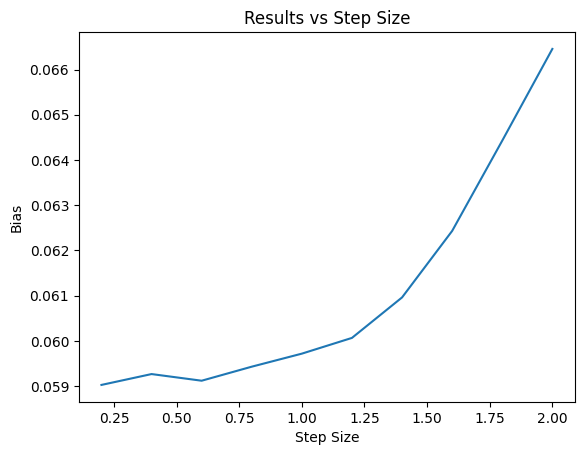

In [4]:
import matplotlib.pyplot as plt

# Extract step_size and bias values from the keys of the results dictionary
step_sizes = [key[1] for key in results.keys()]
biases = list(results.values())

# Plot the results
plt.plot(step_sizes, biases)
plt.xlabel('Step Size')
plt.ylabel('Bias')
plt.title('Results vs Step Size')
plt.show()


array([0.97743])

In [9]:
import seaborn as sns

import matplotlib.pyplot as plt

# Extract x and y values from the keys of the results dictionary
x_values = [key[0] for key in results.keys()]
y_values = [key[1] for key in results.keys()]

print(len(x_values))
# raise Exception

# Extract heat values from the dictionary
heat_values = list(results.values())


# Reshape the heat values into a 2D array
# heat_array = np.array(heat_values).reshape((len(x_values), len(y_values)))
heat_array = np.array(heat_values).reshape((10,2))

# Create the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(heat_array, annot=True, cmap='viridis')
plt.xlabel('num steps per traj')
plt.ylabel('step size')
plt.title('Heatmap of Results')
plt.show()


2


ValueError: cannot reshape array of size 2 into shape (10,2)

In [10]:
results

defaultdict(float,
            {('simple', (10.0, 1.0)): Array(0.18656716, dtype=float32),
             ('simple',
              (10.0, 1.4444444444444444)): Array(0.25452492, dtype=float32),
             ('simple',
              (10.0, 1.8888888888888888)): Array(0.24509802, dtype=float32),
             ('simple',
              (10.0, 2.333333333333333)): Array(0.17281109, dtype=float32),
             ('simple',
              (10.0, 2.7777777777777777)): Array(0.17999998, dtype=float32),
             ('simple',
              (10.0, 3.2222222222222223)): Array(0.14502098, dtype=float32),
             ('simple',
              (10.0, 3.6666666666666665)): Array(0.15321758, dtype=float32),
             ('simple',
              (10.0, 4.111111111111111)): Array(0.1253831, dtype=float32),
             ('simple',
              (10.0, 4.555555555555555)): Array(0.11315059, dtype=float32),
             ('simple', (10.0, 5.0)): Array(0.11111111, dtype=float32),
             ('simple',
         

In [5]:
print(results)

defaultdict(<class 'float'>, {('Banana', 0.97743, 16.866055): (Array(0., dtype=float32), Array(0.05961667, dtype=float32))})
